# Getting started with GABA-edited MRS Artifact Simulation Toolbox

Based on Artifact Simulation Toolbox by Hanna Bugler, Rodrigo Berto, Roberto Souza and Ashley Harris (2023)

In [1]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from gaba_edited_artifact_simulation_toolbox import to_fids, to_specs, interleave, undo_interleave, scale, undo_scale
from gaba_edited_artifact_simulation_toolbox import add_time_domain_noise, add_freq_shift_random, add_phase_shift_random, add_eddy_current_artifact, add_ghost_artifact, add_lipid_artifact
from gaba_edited_artifact_simulation_toolbox import add_disruptive_motion_artifact, add_subtle_motion_artifact, add_progressive_motion_artifact

## Loading ground truths and preparing data
> Function and plotting default values are set up for scaled data <br>
> Data assumed to be in local folder
> If a parameter is not set or the length of the parameter value array is incompatible with the number of artifacts asked of the function, default values will be used

In [2]:
# Load Necessary Data
ppm = np.load(f"ppm_Sim.npy")
time = np.load(f"time_Sim.npy")
fids_on_gt = np.load(f"fidsOnGABA.npy")
fids_off_gt = np.load(f"fidsOffGABA.npy")

# Simulate Scan
fids_on = fids_on_gt.repeat(160, axis=0)
fids_off = fids_off_gt.repeat(160, axis=0)
fids = interleave(fids_off=fids_off, fids_on=fids_on)
fids, scaleFact = scale(fids)

# Prepare Data
mean_specs_gt = (to_specs(fids[0:1, :]) - to_specs(fids[1:2, :]))[0, :]
start, end = np.where(ppm <= 0.01)[0][-1], np.where(ppm >= 4.53)[0][0]

In [3]:
# Add Complex Gaussian White Noise
fids = add_time_domain_noise(fids, noise_level=0.00001)

## Add and Visualize Artifacts in Data

### Eddy Current Artifacts

$FID = FID_0  \ast e^{-2\pi t A e^{t/t_c}}$

> User flexible parameters:
> > EcLocs (locations) <br>
> > A/amp (amplitude) <br>
> > Tc/tc (time constant of decaying artifact) 

In [4]:
# Add Eddy Current Artifact(s)
fids_ec, artif_locs_ec = add_eddy_current_artifact(np.copy(fids), time, nmb_ecs=1, ec_locs=[6], amp=[2.0])
print(f'Eddy Current artifact(s) inserted at transient #s: {artif_locs_ec}.')

Non-user defined parameters: ['Time Constants']
Eddy Current artifact(s) inserted at transient #s: [6].


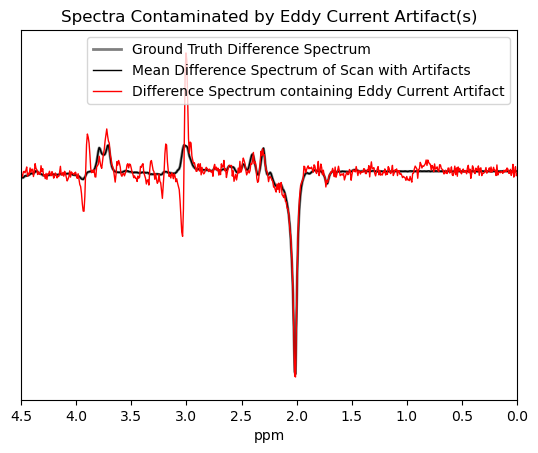

In [5]:
# Prepare Data for Plotting
on_specs, off_specs = undo_interleave(to_specs(fids_ec))
diff_specs = (on_specs - off_specs)

for ii in artif_locs_ec:
    if ii%2==0:
        artif_loc = int(ii/2)
    else:
        artif_loc = int((ii-1)/2)

# Plot Artifact(s)
fig1, (ax1) = plt.subplots(1)
ax1.set_title(f"Spectra Contaminated by Eddy Current Artifact(s)")
ax1.plot(ppm, mean_specs_gt.real, 'grey', linewidth=2, label="Ground Truth Difference Spectrum")
ax1.plot(ppm, diff_specs.mean(axis=0).real, color='black', linewidth=1, label="Mean Difference Spectrum of Scan with Artifacts")
ax1.plot(ppm, diff_specs[artif_loc, :].real, color='red', linewidth=1, label="Difference Spectrum containing Eddy Current Artifact")
ax1.set_xlim(0.0, 4.5)
ax1.invert_xaxis()
ax1.set_xlabel('ppm')
ax1.set_ylim(np.min(diff_specs[artif_loc, start:end].real)-0.005, np.max(diff_specs[artif_loc, start:end].real)+0.005)
ax1.get_yaxis().set_visible(False)
plt.legend()
plt.show()

### Ghost / Spurious Echo Artifact
$FID(t) = \left\{ \begin{array}{cl}
FID_0,& \ t_s \gt t \gt t_f \\
FID_0\ast A\ast e^{-\left| t \right|/T_{all})}\ast e^{-j(\ast t \ast lf \ast (1-Cs)+\theta)},& \ t_s \le  t \le  t_f \\
\end{array} \right.$

> User flexible parameters:
> > gLocs (locations) <br>
> > A/amp (amplitude) <br>
> > Cs/cs (chemical shift of main artifact) <br>
> > $\theta$/phase (phase of the artifact) <br>
> > tstart (start of artifact in FID) <br> 
> > tfinish (end of artifact in FID) <br> 

In [6]:
# Add Ghost / Spurious Echo Artifact(s)
fids_gs, artif_locs_gs = add_ghost_artifact(np.copy(fids), time, nmb_ghosts=1, gs_locs=[74], tstart=[750], tfinish=[850], amp=[25], cs=[8.5], phase=[1])
print(f'Ghost / Spurious Echo artifact(s) inserted at transient #s: {artif_locs_gs}.')

Ghost / Spurious Echo artifact(s) inserted at transient #s: [74].


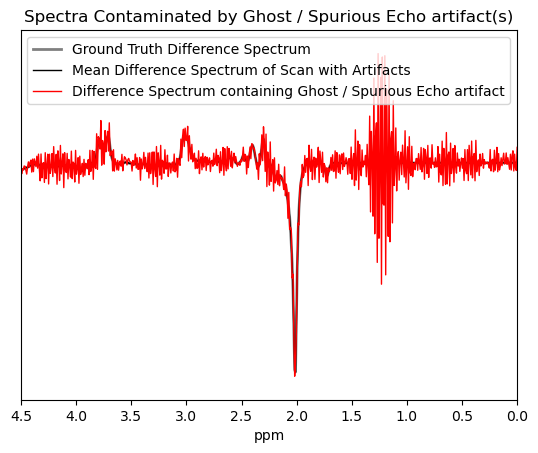

In [7]:
# Prepare Data for Plotting
on_specs, off_specs = undo_interleave(to_specs(fids_gs))
diff_specs = (on_specs - off_specs)

for ii in artif_locs_gs:
    if ii%2==0:
        artif_loc = int(ii/2)
    else:
        artif_loc = int((ii-1)/2)

# Plot Artifact(s)
fig1, (ax1) = plt.subplots(1)
ax1.set_title(f"Spectra Contaminated by Ghost / Spurious Echo artifact(s)")
ax1.plot(ppm, mean_specs_gt.real, 'grey', linewidth=2, label="Ground Truth Difference Spectrum")
ax1.plot(ppm, diff_specs.mean(axis=0).real, color='black', linewidth=1, label="Mean Difference Spectrum of Scan with Artifacts")
ax1.plot(ppm, diff_specs[artif_loc, :].real, color='red', linewidth=1, label="Difference Spectrum containing Ghost / Spurious Echo artifact")
ax1.set_xlim(0.0, 4.5)
ax1.invert_xaxis()
ax1.set_xlabel('ppm')
ax1.set_ylim(np.min(diff_specs[artif_loc, start:end].real)-0.005, np.max(diff_specs[artif_loc, start:end].real)+0.005)
ax1.get_yaxis().set_visible(False)
plt.legend()
plt.show()

### Disruptive Motion (Linebroadening and Baseline Distortion)
$FID(t) = FID_0 \ast A \ast e^{-t \ast lvs}$
<br>
> User flexible parameters:
> > motLocs (locations) <br>
> > A/amp (amplitude) <br>
> > lvs (lineshape variance)

In [8]:
# Add Linebroadening and Baseline Distortion
fids_dm, artif_locs_dm = add_disruptive_motion_artifact(np.copy(fids), time, ppm, amp=[2], lvs=[30], mot_locs=[26], nmb_motion=1)
print(f'Linebroadening and Baseline Distortion inserted at transient #s: {artif_locs_dm}.')

Linebroadening and Baseline Distortion inserted at transient #s: [26].


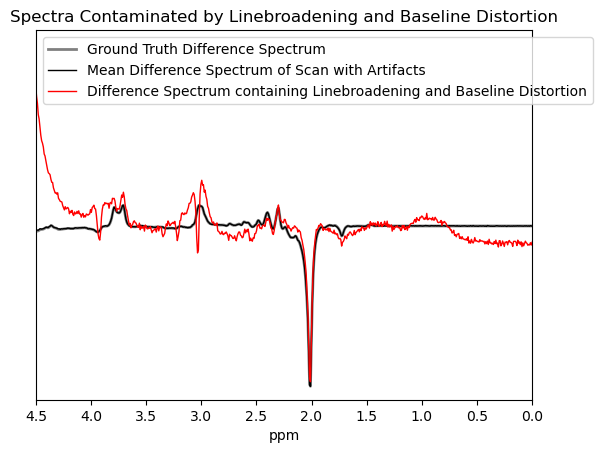

In [9]:
# Prepare Data for Plotting
on_specs, off_specs = undo_interleave(to_specs(fids_dm))
diff_specs = (on_specs - off_specs)

for ii in artif_locs_dm:
    if ii%2==0:
        artif_loc = int(ii/2)
    else:
        artif_loc = int((ii-1)/2)

# Plot Artifact(s)
fig1, (ax1) = plt.subplots(1)
ax1.set_title(f"Spectra Contaminated by Linebroadening and Baseline Distortion")
ax1.plot(ppm, mean_specs_gt.real, 'grey', linewidth=2, label="Ground Truth Difference Spectrum")
ax1.plot(ppm, diff_specs.mean(axis=0).real, color='black', linewidth=1, label="Mean Difference Spectrum of Scan with Artifacts")
ax1.plot(ppm, diff_specs[artif_loc, :].real, color='red', linewidth=1, label="Difference Spectrum containing Linebroadening and Baseline Distortion")
ax1.set_xlim(0.0, 4.5)
ax1.invert_xaxis()
ax1.set_xlabel('ppm')
ax1.set_ylim(np.min(diff_specs[artif_loc, start:end].real)-0.005, np.max(diff_specs[artif_loc, start:end].real)+0.005)
ax1.get_yaxis().set_visible(False)
plt.legend()
plt.show()

### Progressive Motion (Linear Frequency Drift)
$FID(t) = FID_0 \ast e^{-j2\pi t \ast noise_{linear}}$
<br>
> User flexible parameters:
> > Freq_shift (overall frequency shift experienced) <br>
> > startTrans (first transient involved in shift) <br>
> > numTrans (total number of transients involved in shift) <br>
> > Freq_offset_var (variation of offset of frequency noise during drift) <br>

In [10]:
# Add Frequency Drift over Numerous Consecutive Transients
fids_pm, trans_affected = add_progressive_motion_artifact(time, np.copy(fids), num_affected_trans=320, slope_var=15)
print(f'Frequency Drift over Numerous Consecutive Transients begins at transient #{trans_affected[0]} and ends at transient #{trans_affected[1]}.')

Non-user defined parameters: ['First Transient', 'Offset Variation']
Frequency Drift over Numerous Consecutive Transients begins at transient #0 and ends at transient #320.


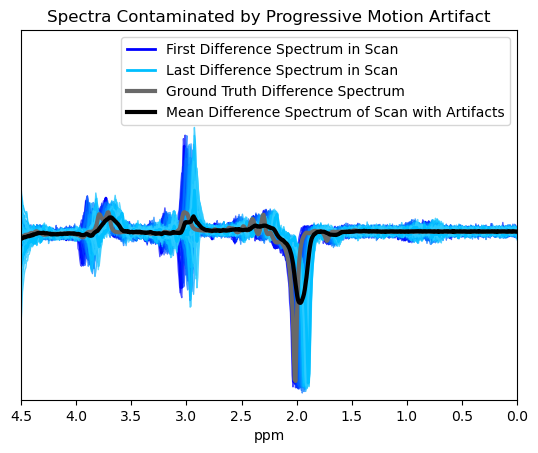

In [19]:
# Progressive Motion
on_specs, off_specs = undo_interleave(to_specs(fids_pm))
diff_specs = (on_specs - off_specs)

cmap = colors.LinearSegmentedColormap.from_list("", ["blue", "deepskyblue", "lightcyan"])
fig1, (ax1) = plt.subplots(1)
ax1.set_title(f"Spectra Contaminated by Progressive Motion Artifact")
ax1.plot(ppm, diff_specs[0, :].real, linewidth=2, color='blue', alpha=1, label="First Difference Spectrum in Scan")
for ii in range(1, (diff_specs.shape[0]-2)):
    ax1.plot(ppm, diff_specs[ii, :].real, linewidth=1, color=cmap(ii), alpha=0.7)
ax1.plot(ppm, diff_specs[diff_specs.shape[0]-1, :].real, linewidth=2, color='deepskyblue', alpha=1, label="Last Difference Spectrum in Scan")
ax1.plot(ppm, mean_specs_gt.real, 'dimgrey', linewidth=3, label="Ground Truth Difference Spectrum")
ax1.plot(ppm, diff_specs.mean(axis=0).real, 'black', linewidth=3, label="Mean Difference Spectrum of Scan with Artifacts")
ax1.set_xlim(0.0, 4.5)
ax1.invert_xaxis()
ax1.set_xlabel('ppm')
ax1.set_ylim(-0.05, 0.06)
ax1.get_yaxis().set_visible(False)
plt.legend()
plt.show()

### Subtle Motion (Random Frequency and Phase Shifts)
$FID(t) = FID_0 \ast e^{-j2\pi t \ast noise_{frequency}}$
<br>
$FID(t) = FID_0 \ast e^{-j\frac{\pi}{180}\ast noise_{phase}}$
<br>
> User flexible parameters:
> > freqShiftVar (range of frequency shifts) <br>
> > phaseShiftVar (range of phase shifts) <br>

In [5]:
# Add Small Frequency and Phase Shift(s)
fids_sm, trans_affected = add_subtle_motion_artifact(np.copy(fids), time, num_affected_trans=int(fids.shape[0]/2), freq_shift_var=20, phase_shift_var=30)
print(f'{len(trans_affected[0])} transients frequency shifted, Transient Numbers Affected: {trans_affected[0]}')
print(f'{len(trans_affected[1])} transients phase shifted, Transient Numbers Affected: {trans_affected[1]}')

Non-user defined parameters: ['Clustering']
Non-user defined parameters: ['Clustering']
160 transients frequency shifted, Transient Numbers Affected: [  0   1   2   7   8   9  10  12  14  15  19  25  26  27  29  30  31  32
  33  35  36  38  39  41  43  46  47  48  49  50  51  52  55  58  61  64
  66  69  71  74  75  76  78  81  82  84  88  90  91  92  93  94  96  97
  98  99 100 101 102 103 107 112 113 118 121 122 124 128 133 135 136 137
 138 139 142 144 145 148 150 152 154 158 159 160 161 164 166 169 174 177
 178 179 180 188 189 190 191 192 193 194 195 197 199 200 204 207 208 209
 211 212 213 214 217 219 224 228 231 232 233 234 238 240 242 245 247 248
 250 251 254 257 258 260 262 265 266 268 271 272 274 275 276 278 280 281
 282 284 286 291 296 297 298 304 305 309 310 312 313 316 317 318]
160 transients phase shifted, Transient Numbers Affected: [  0   2   3   5   7  10  11  12  13  15  16  19  21  24  25  27  28  29
  31  32  33  34  35  36  37  38  42  43  46  47  48  50  51  53  54 

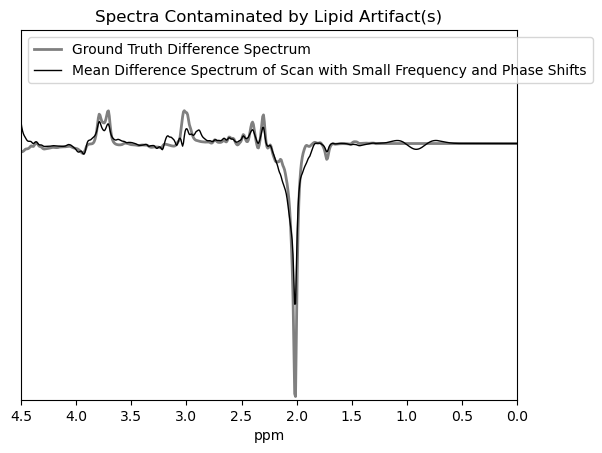

In [6]:
# Prepare Data for Plotting
on_specs, off_specs = undo_interleave(to_specs(fids_sm))
diff_specs = (on_specs - off_specs)

# Plot Artifact(s)
fig1, (ax1) = plt.subplots(1)
ax1.set_title(f"Spectra Contaminated by Lipid Artifact(s)")
ax1.plot(ppm, mean_specs_gt.real, 'grey', linewidth=2, label="Ground Truth Difference Spectrum")
ax1.plot(ppm, diff_specs.mean(axis=0).real, color='black', linewidth=1, label="Mean Difference Spectrum of Scan with Small Frequency and Phase Shifts")
ax1.set_xlim(0.0, 4.5)
ax1.invert_xaxis()
ax1.set_xlabel('ppm')
ax1.set_ylim(-0.045, 0.02)
ax1.get_yaxis().set_visible(False)
plt.legend()
plt.show()

### Lipid Artifacts

$Spec(f) = \left\{ \begin{array}{cl}
Spec_0,& \ f_s \gt f \gt f_f \\
Spec_0\ast (A_1 \ast e^{-(f-f_1)^{2}}) \ast (A_2 \ast e^{-(f-f_2)^{2}}),& \ f_s \le  f \le  f_f \\
\end{array} \right.$

<br>

$Spec(f) = \left\{ \begin{array}{cl}
Spec_0,& \ f_s \gt f \gt f_f \\
Spec_0\ast \left| \sin(B\ast f) \right|,& \ f_s \le  f \le  f_f \\
\end{array} \right.$

<br>

> User flexible parameters:
> > lpLocs (locations) <br>
> > A1 & A2 / avgAmp (average amplitude of Gaussians) <br>
> > F1 & F2 / glob_loc (frequency domain location of peak) <br>

In [13]:
# Add Lipid Artifact(s)
fids_lp, artif_locs_lp = add_lipid_artifact(np.copy(fids), ppm, edited=True, avg_amp=0.0025, lp_locs= [8, 9], nmb_lps=2)
print(f'Lipid Artifact(s) inserted at transient #s: {artif_locs_lp}.')

Lipid Artifact(s) inserted at transient #s: [8, 9].


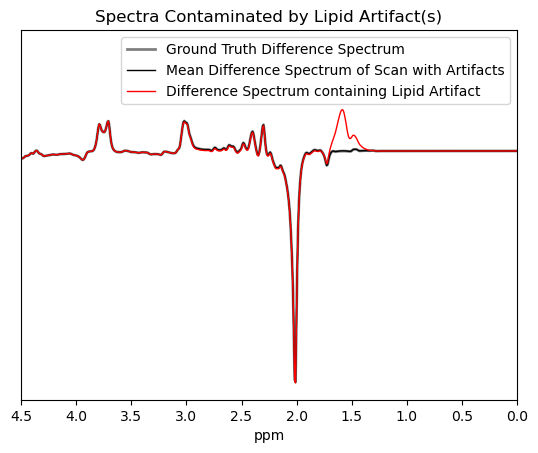

In [14]:
# Prepare Data for Plotting
on_specs, off_specs = undo_interleave(to_specs(fids_lp))
diff_specs = (on_specs - off_specs)

for ii in artif_locs_lp:
    if ii%2==0:
        artif_loc = int(ii/2)
    else:
        artif_loc = int((ii-1)/2)

# Plot Artifact(s)
fig1, (ax1) = plt.subplots(1)
ax1.set_title(f"Spectra Contaminated by Lipid Artifact(s)")
ax1.plot(ppm, mean_specs_gt.real, 'grey', linewidth=2, label="Ground Truth Difference Spectrum")
ax1.plot(ppm, diff_specs.mean(axis=0).real, color='black', linewidth=1, label="Mean Difference Spectrum of Scan with Artifacts")
ax1.plot(ppm, diff_specs[artif_loc, :].real, color='red', linewidth=1, label="Difference Spectrum containing Lipid Artifact")
ax1.set_xlim(0.0, 4.5)
ax1.invert_xaxis()
ax1.set_xlabel('ppm')
ax1.get_yaxis().set_visible(False)
plt.legend()
plt.show()

In [ ]:
# Save Data (change individualized fids (ex: LPFids) to fids and remove np.copy() instances for artifact functions to apply to single copy of scan)
fids = undo_scale(fids, scaleFact)
fids_on_final, fids_off_final = undo_interleave(fids)

np.save(f"fidsOnGABA_contaminated.npy", fids_on_final)
np.save(f"fidsOffGABA_contaminated.npy", fids_off_final)